In [1]:
# подключение библиотек

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('custom_modules')

import Data_processing as dp

from IPython.display import display
from matplotlib import ticker
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Пути к X части выборки с массивами в каждой ячейке
path_to_array_like_X_data = 'data/Prepared data/Run1/X_data_array_like.xlsx'
# Пути к Y части выборки
path_to_Y_data = 'data/Prepared data/Run1/Y_data(binary_classification).xlsx'


### Константы для обработки данных

In [3]:
# размер кропа
PREP_image_size = 10
# шаг кропа
PREP_crop_step = 5

In [4]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

# Подготовка данных

In [5]:
# расширить датафрейм, добавив справа 63 первых столбца
# и снизу 63 первых строки
def extend_df_for_prediction(df, crop_size, crop_step):

    print('||||||||||||||||||')
    print('Df extending for better prediction')
    print('Original df size: ', df.shape)
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', crop_step)

    extend_dims = crop_size - 1
    
    df = pd.concat([df,df.iloc[:,:extend_dims]],axis=1,ignore_index=True)
    df = pd.concat([df,df.iloc[:extend_dims,:]],axis=0,ignore_index=True)
        
    print('New df shape: ', df.shape)
    print('||||||||||||||||||\n')

    dp.reshape_df_for_future_crops(df,crop_size,crop_step)
    
    return df

In [6]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

X_dict['df'] =  dp.get_array_like_X_df(path_to_array_like_X_data)
Y_dict['df'] =  dp.get_Y_df(path_to_Y_data)

#X_dict['df'] = pd.concat([X_dict['df'].iloc[:,200:],X_dict['df'].iloc[:,:200]],axis=1,ignore_index=True)
#Y_dict['df'] = pd.concat([Y_dict['df'].iloc[:,200:],Y_dict['df'].iloc[:,:200]],axis=1,ignore_index=True)

### Оригинальная развернутая карта дефектов

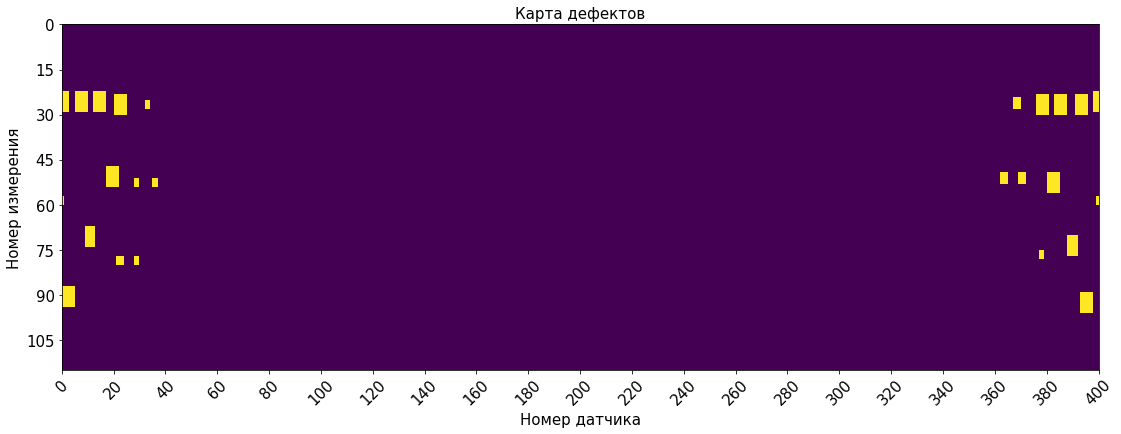

In [7]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])
axes.invert_yaxis()

axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 
     
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

In [8]:
# Добавление строк в датафреймы
# Справа к каждому датафрейму дописывается по 63
# элемента, чтобы сымитировать сканирование 
# трубы по всей окружности фильтром размера 64 на 64
# а еще дописывается некоторое количество строк и столбцов
# меньшее чем шаг кропа. Чтобы датафрейм можно было поделить
# на целое кол-во кропов

print('||||||||||| X df preprocessing |||||||||||')
#X_dict['df'] = dp.reshape_df_for_future_crops(X_dict['df'], PREP_image_size, PREP_crop_step)
X_dict['df'] = extend_df_for_prediction(X_dict['df'], PREP_image_size, PREP_crop_step)

print('||||||||||| Y df preprocessing |||||||||||')
#Y_dict['df'] = dp.reshape_df_for_future_crops(Y_dict['df'], PREP_image_size, PREP_crop_step)
Y_dict['df'] = extend_df_for_prediction(Y_dict['df'], PREP_image_size, PREP_crop_step)

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Df extending for better prediction
Original df size:  (115, 400)
Crop windows height/width:  10
Crop windows step across rows and cols:  5
New df shape:  (124, 409)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (124, 409)
Crop windows height/width:  10
Crop windows step across rows and cols:  5
New df shape:  (125, 410)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Df extending for better prediction
Original df size:  (115, 400)
Crop windows height/width:  10
Crop windows step across rows and cols:  5
New df shape:  (124, 409)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (124, 409)
Crop windows height/width:  10
Crop windows step across rows and cols:  5
New df shape:  (125, 410)
||||||||||||||||||



### Расширенная развернутая карта дефектов

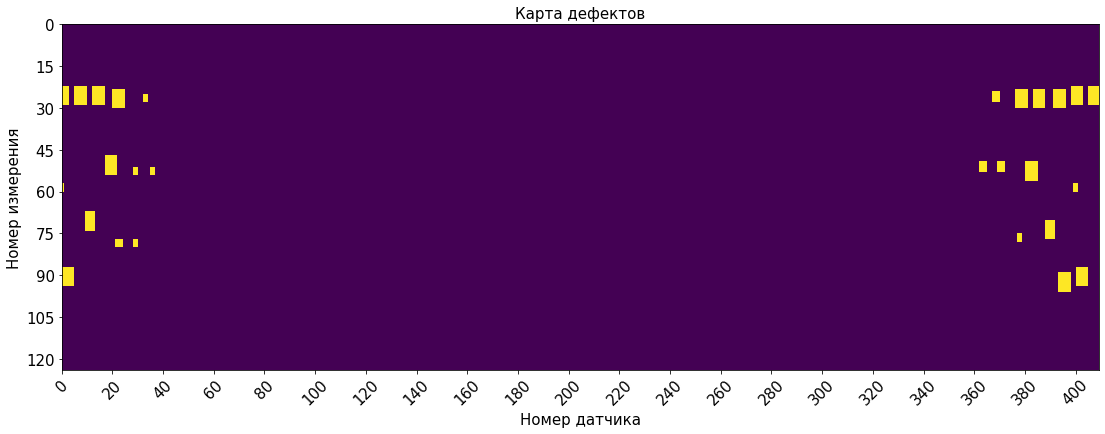

In [9]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])
axes.invert_yaxis()

axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

In [10]:
# запишем в словарь numpy array полученные из df

print('||||||||||| X df preprocessing |||||||||||')
x_time_temp, \
x_amp_temp = dp.reshape_X_df_to_image_like_numpy(X_dict['df'], 
                                                    PREP_image_size, 
                                                    PREP_crop_step)
X_dict['X_time_all'] = x_time_temp.astype('float32')
X_dict['X_amp_all'] = x_amp_temp.astype('float32')

X_dict.pop('df',0)

print('||||||||||| Y df preprocessing |||||||||||')
y_temp = dp.reshape_Y_df_to_image_like_numpy(Y_dict['df'], 
                                             PREP_image_size, 
                                             PREP_crop_step)
Y_dict['Y_mask_all'] = y_temp.astype('int8')

Y_dict.pop('df',0)

print('\n')

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (124, 409)
Crop windows height/width:  10
Crop windows step across rows and cols:  5
New X_time shape:  (1840, 10, 10, 32)
New X_amp shape:  (1840, 10, 10, 32)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Y df reshaping to 3D
Original df size:  (124, 409)
Crop windows height/width:  10
Crop windows step across rows and cols:  5
New numpy shape:  (1840, 10, 10, 1)
||||||||||||||||||





In [11]:
# что есть на данный момент

print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"{key}.shape: ", X_dict[key].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"{key}.shape: ", Y_dict[key].shape)

|||||||||||||| X dataset ||||||||||||||||
X_time_all.shape:  (1840, 10, 10, 32)
X_amp_all.shape:  (1840, 10, 10, 32)

|||||||||||||| Y dataset ||||||||||||||||
Y_mask_all.shape:  (1840, 10, 10, 1)


In [12]:
# нормализация данных

print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"|||||||||||||| dataset part: {key}||||||||||||||||")
    X_dict[key] = dp.normalize_data(X_dict[key])

|||||||||||||| X dataset ||||||||||||||||
|||||||||||||| dataset part: X_time_all||||||||||||||||
||||||||||||||||||
Data normalizing
arr_max before normalization: 44.5
arr_max after normalization: 1.0
arr_min after normalization: 0.0
||||||||||||||||||
|||||||||||||| dataset part: X_amp_all||||||||||||||||
||||||||||||||||||
Data normalizing
arr_max before normalization: 62.992000579833984
arr_max after normalization: 1.0
arr_min after normalization: -0.9837439060211182
||||||||||||||||||


In [13]:
# деление данных на дефектные и нет

(X_time_def, X_time_non_def), \
(X_amp_def, X_amp_non_def), \
(Y_mask_def, Y_mask_non_def) = dp.split_def_and_non_def_data(X_dict['X_time_all'], 
                                                                X_dict['X_amp_all'], 
                                                                Y_dict['Y_mask_all'],
                                                                PREP_image_size)
X_dict.pop('X_time_all',0)
X_dict.pop('X_amp_all',0)
Y_dict.pop('Y_mask_all',0)
print()

X_dict['X_time_def'] = X_time_def
X_dict['X_time_non_def'] = X_time_non_def

X_dict['X_amp_def'] = X_amp_def
X_dict['X_amp_non_def'] = X_amp_non_def

Y_dict['Y_mask_def'] = Y_mask_def
Y_dict['Y_mask_non_def'] = Y_mask_non_def

||||||||||||||||||
Defect and non defect data splitting
Orig X_time shape:  (1840, 10, 10, 32)
Orig X_amp shape:  (1840, 10, 10, 32)
Orig Y_mask shape:  (1840, 10, 10, 1)
||||||||||||||||||
Defects nums calculating
Для карт высотой и шириной в 10
и общим кличеством: 1840
дефекты присутствуеют на 127 картах
||||||||||||||||||

X_time_def shape:  (127, 10, 10, 32)
X_time_non_def shape:  (1713, 10, 10, 32)

X_amp_def shape:  (127, 10, 10, 32)
X_amp_non_def shape:  (1713, 10, 10, 32)

Y_mask_def shape:  (127, 10, 10, 1)
Y_mask_non_def shape:  (1713, 10, 10, 1)

||||||||||||||||||




In [14]:
# аугментация данных

print('|||||||||||||| X dataset ||||||||||||||||')

print(f"|||||||||||||| dataset part: X_time_def||||||||||||||||")
X_dict['X_time_def'] = dp.augment_data(X_dict['X_time_def']) 

print(f"|||||||||||||| dataset part: X_amp_def||||||||||||||||")
X_dict['X_amp_def'] = dp.augment_data(X_dict['X_amp_def']) 

print('|||||||||||||| Y dataset ||||||||||||||||')

print(f"|||||||||||||| dataset part: Y_mask_def||||||||||||||||")
Y_dict['Y_mask_def'] = dp.augment_data(Y_dict['Y_mask_def']) 

|||||||||||||| X dataset ||||||||||||||||
|||||||||||||| dataset part: X_time_def||||||||||||||||
||||||||||||||||||
Data augmentation
Orig arr shape:  (127, 10, 10, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (508, 10, 10, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (1016, 10, 10, 32)
||||||||||||
After vertical full mirroring
arr shape:  (2032, 10, 10, 32)
||||||||||||||||||

|||||||||||||| dataset part: X_amp_def||||||||||||||||
||||||||||||||||||
Data augmentation
Orig arr shape:  (127, 10, 10, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (508, 10, 10, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (1016, 10, 10, 32)
||||||||||||
After vertical full mirroring
arr shape:  (2032, 10, 10, 32)
||||||||||||||||||

|||||||||||||| Y dataset ||||||||||||||||
|||||||||||||| dataset part: Y_mask_def||||||||||||||||
||||||||||||||||||
Data augmentation
Orig arr shape:  (127, 10, 10, 1)
||||||||||||
After 4 steps of 90 degree 

In [15]:
# что есть на данный момент

print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"{key}.shape: ", X_dict[key].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"{key}.shape: ", Y_dict[key].shape)

|||||||||||||| X dataset ||||||||||||||||
X_time_def.shape:  (2032, 10, 10, 32)
X_time_non_def.shape:  (1713, 10, 10, 32)
X_amp_def.shape:  (2032, 10, 10, 32)
X_amp_non_def.shape:  (1713, 10, 10, 32)

|||||||||||||| Y dataset ||||||||||||||||
Y_mask_def.shape:  (2032, 10, 10, 1)
Y_mask_non_def.shape:  (1713, 10, 10, 1)


In [16]:
# деление на тренировочную и валидационную выборки

val_data_percent = 0.2

X_time_train, X_time_val = dp.split_data_to_train_val_datasets([X_dict['X_time_def'],
                                                                X_dict['X_time_non_def']],
                                                                val_data_percent)
        
X_dict.pop('X_time_def',0)
X_dict.pop('X_time_non_def',0)


X_amp_train, X_amp_val = dp.split_data_to_train_val_datasets([X_dict['X_amp_def'],
                                                              X_dict['X_amp_non_def']],
                                                              val_data_percent)

X_dict.pop('X_amp_def',0)
X_dict.pop('X_amp_non_def',0)


Y_mask_train, Y_mask_val = dp.split_data_to_train_val_datasets([Y_dict['Y_mask_def'],
                                                                Y_dict['Y_mask_non_def']],
                                                                    val_data_percent)

Y_dict.pop('Y_mask_def',0)
Y_dict.pop('Y_mask_non_def',0)

print()

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (2032, 10, 10, 32)
Orig item shape:  (1713, 10, 10, 32)

Result arr_train shape:  (2997, 10, 10, 32)
Result arr_val shape:  (748, 10, 10, 32)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (2032, 10, 10, 32)
Orig item shape:  (1713, 10, 10, 32)

Result arr_train shape:  (2997, 10, 10, 32)
Result arr_val shape:  (748, 10, 10, 32)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (2032, 10, 10, 1)
Orig item shape:  (1713, 10, 10, 1)

Result arr_train shape:  (2997, 10, 10, 1)
Result arr_val shape:  (748, 10, 10, 1)

||||||||||||||||||




In [17]:
# очистка памяти от лишнего   
X_dict.clear()
Y_dict.clear()

In [18]:
# перемешивание данных

train_shuffled_indices = np.random.permutation(X_time_train.shape[0])
val_shuffled_indices = np.random.permutation(X_time_val.shape[0])

X_time_train = X_time_train[train_shuffled_indices]
X_amp_train = X_amp_train[train_shuffled_indices]
Y_mask_train = Y_mask_train[train_shuffled_indices]

X_time_val = X_time_val[val_shuffled_indices]
X_amp_val = X_amp_val[val_shuffled_indices]
Y_mask_val = Y_mask_val[val_shuffled_indices]

In [19]:
# что есть на данный момент

print('X_time_train.shape: ', X_time_train.shape)
print('X_amp_train.shape: ', X_amp_train.shape)
print('Y_mask_train.shape', Y_mask_train.shape)
print('\n')

print('X_time_val.shape: ', X_time_val.shape)
print('X_amp_val.shape: ', X_amp_val.shape)
print('Y_mask_val.shape', Y_mask_val.shape)
print('\n')

X_time_train.shape:  (2997, 10, 10, 32)
X_amp_train.shape:  (2997, 10, 10, 32)
Y_mask_train.shape (2997, 10, 10, 1)


X_time_val.shape:  (748, 10, 10, 32)
X_amp_val.shape:  (748, 10, 10, 32)
Y_mask_val.shape (748, 10, 10, 1)




# CNN с 2 входами по времени и амплитуде

In [20]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.12 # шаг сходимости back propogation
#CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'binary_crossentropy'#'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 4 # размер bach при обучении/тестировании1
FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 20 # количество эпох обучения

In [21]:
input_time = Input((10,10,32))
t = Conv2D(128, (2,2), padding='same', activation='relu', input_shape=(28,28,1))(input_time)
t = Conv2D(128, (2,2), padding='same', activation='relu')(t)
t = MaxPooling2D((2,2), strides=2)(t)
t = Conv2D(512, (2,2), padding='same', activation='relu')(t)
t = Conv2D(512, (2,2), padding='same', activation='relu')(t)
t = BatchNormalization()(t)
output_time = Flatten()(t)

input_amp = Input((10,10,32))
a = Conv2D(128, (2,2), padding='same', activation='linear', input_shape=(28,28,1))(input_amp)
a = Conv2D(128, (2,2), padding='same', activation='linear')(a)
a = MaxPooling2D((2,2), strides=2)(a)
a = Conv2D(512, (2,2), padding='same', activation='linear')(a)
a = Conv2D(512, (2,2), padding='same', activation='linear')(a)
a = BatchNormalization()(a)
output_amp = Flatten()(a)

at = concatenate([output_time,output_amp])
at = Reshape((8,8,400))(at)
at = Conv2D(200, (2,2), padding='same', activation='linear')(at)
at = Conv2D(200, (2,2), padding='same', activation='linear')(at)
at = MaxPooling2D((2,2), strides=2)(at)
at = Conv2D(100, (2,2), padding='same', activation='linear')(at)
at = Conv2D(100, (2,2), padding='same', activation='linear')(at)
at = MaxPooling2D((2,2), strides=2)(at)
at = Conv2D(50, (2,2), padding='same', activation='relu')(at)
at = Conv2D(25, (2,2), padding='same', activation='sigmoid')(at)


output = Reshape((10,10,1))(at)

model = keras.Model([input_time,input_amp], output, name='model')
model.compile(optimizer=CMP_solver, loss=CMP_loss_func)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 10, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 10, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 10, 10, 128)  16512       ['input_1[0][0]']                
                                                                                              

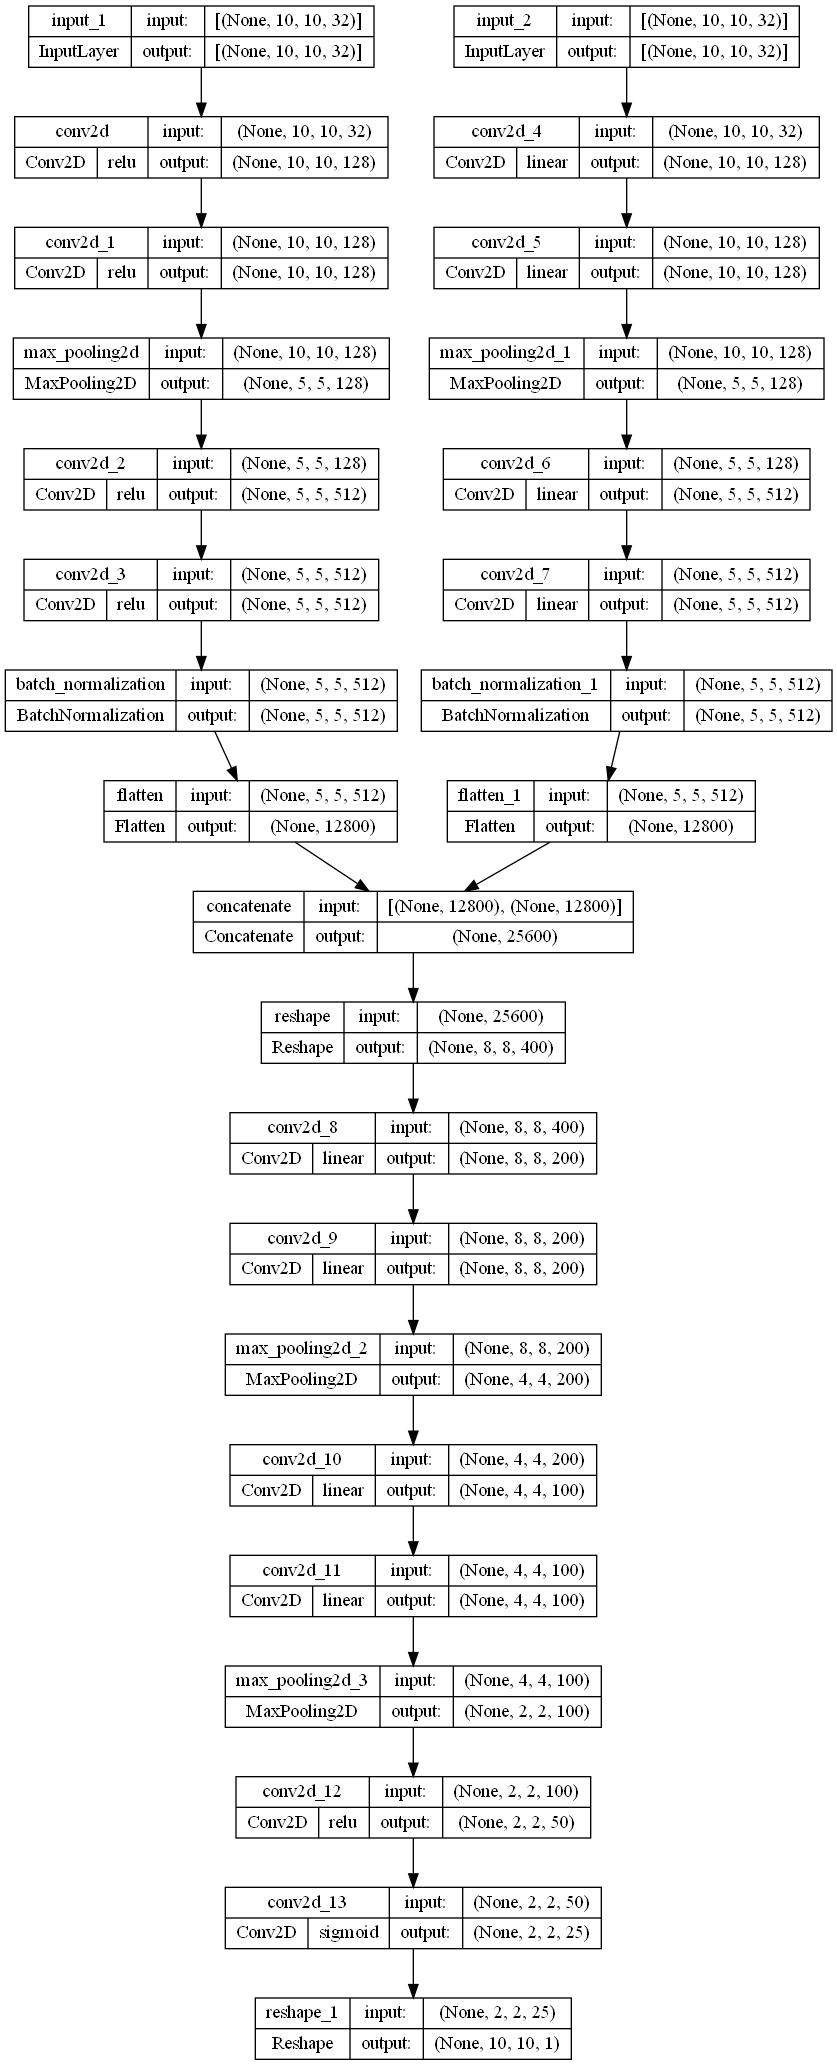

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [23]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [24]:
history = model.fit([X_time_train, X_amp_train],
                    Y_mask_train,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_data = ([X_time_val, X_amp_val], Y_mask_val), 
                    shuffle = FIT_shuffle,
                    callbacks = FIT_callback_list)

750/750 [==============================] - 14s 19ms/step - loss: 0.0012 - val_loss: 0.0138


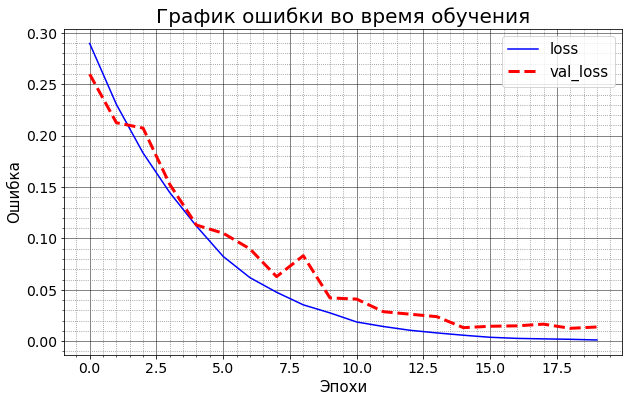

In [25]:
# Вывод графика изменения ошибки

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

plt.plot(history.history['loss'], label='loss',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', label='val_loss',  linewidth=3, color='red')

ax.set_title('График ошибки во время обучения', fontsize=20)
ax.set_ylabel('Ошибка', fontsize=15)
ax.set_xlabel('Эпохи', fontsize=15)

#  Устанавливаем интервал основных делений:
#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

#  Устанавливаем форматирование чисел основных делений:
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))

#  Устанавливаем форматирование делений:
ax.xaxis.set_tick_params(which = 'major', labelsize = 14)
ax.yaxis.set_tick_params(which = 'major', labelsize = 14)

ax.minorticks_on()
ax.grid(which='major', color = 'k', alpha = 0.6)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 15, facecolor = "white", loc = 'upper right')

plt.show()

In [26]:
res = model.predict([X_time_train, X_amp_train])
res.shape

94/94 [==============================] - 2s 22ms/step


(2997, 10, 10, 1)

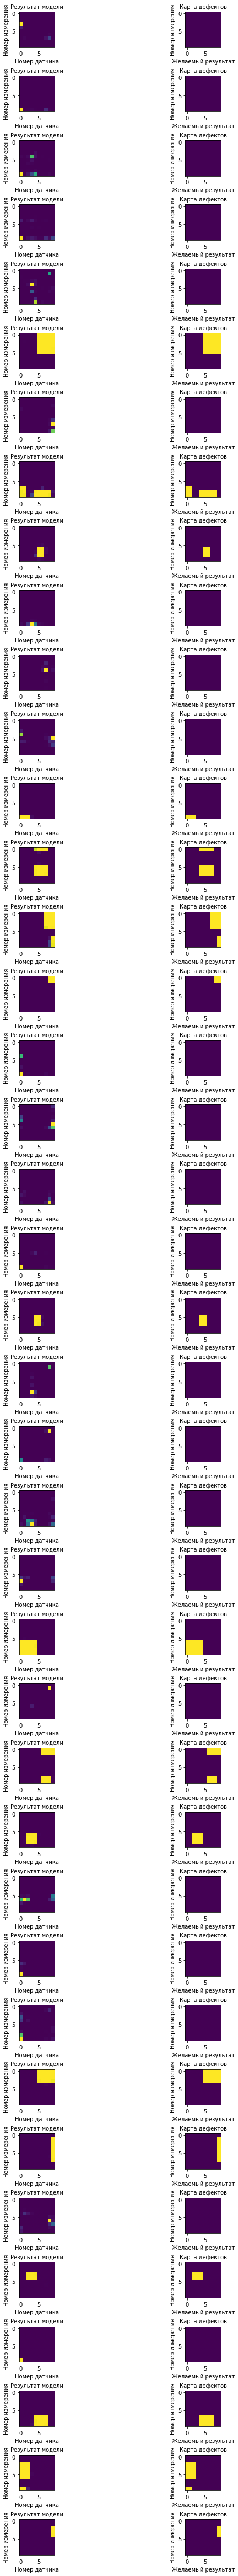

In [27]:
fig, ax = plt.subplots(40,2)

fig.set_figwidth(10)
fig.set_figheight(80)

for i,iax in zip(range(40),ax):
    
    iax[0].imshow(res[i])

    iax[0].set_xlabel('Номер датчика', fontsize=10) 
    iax[0].set_ylabel('Номер измерения', fontsize=10) 
    iax[0].set_title('Результат модели', fontsize=10) 

    iax[1].imshow(Y_mask_train[i])

    iax[1].set_xlabel('Желаемый результат', fontsize=10) 
    iax[1].set_ylabel('Номер измерения', fontsize=10) 
    iax[1].set_title('Карта дефектов', fontsize=10) 

     
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
plt.show()

In [28]:
model.save("Networks//CNN//NetWork_(64x32+64x32)_to(1)_(test_0dot0)_ver_2.h5")